In [30]:
import os
import pandas as pd
import zipfile
import geopandas as  gpd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn
import datetime
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<br/>

## 1. Load NYC Zipcode Zone

In [31]:
FilePath = os.getenv("PUIDATA")+"/HW11/"
os.chdir(FilePath)
zipNYC = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")
# Change ColNames 
zipNYC = zipNYC.rename(columns={'postalCode': "zipcode"})
zipNYC = zipNYC[['zipcode', 'geometry', 'borough', 'PO_NAME']]
zipNYC.zipcode = pd.to_numeric(zipNYC.zipcode)
zipNYC.head()

,zipcode,geometry,borough,PO_NAME
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows


In [32]:
def check_zipcode(zipNYC):
    '''
    check_zipcode is consistant or not
    input: dataframe contains zipcode information
    output: numerical unique zipcode list zipcode_list
    '''

    # Unique Zipcode in NYC
    print "# of All Zipcode: ", zipNYC.zipcode.unique().shape[0]
    print "# of Unique Zipcode: ", zipNYC.shape[0]

    # (Numeric) NYC Zipcode LIST
    zipNYCList = pd.to_numeric(zipNYC.zipcode).values

    # (Numeric NYC Zipcode UNIQUE LIST
    zipNYCList_Unique = np.unique(zipNYCList)
    
    return zipNYCList_Unique,zipNYCList

zipNYCList_Unique,zipNYCList = check_zipcode(zipNYC)

# of All Zipcode:  247
# of Unique Zipcode:  262


<br/><br/>

## 2. Load and Merge Census Business Data

In [34]:
# Create a copy of zipNYC
zip_merged = zipNYC.copy()

# create curated year list
year = datetime.datetime.today().year
YEARS = map(str,range(year-2, year - 23, -1))
YEARS = map(lambda x:x[2:4],YEARS)

def merged_business(YEARS, zip_merged,zipNYCList):
    '''
    merged all the business files
    
    input: year range and original zipcode list
    output: CB
    '''
    
    # Merge(1994-2014)
    for year in YEARS:
        # Name
        fname = str('zbp' + year + 'totals.zip')
        colname_EST = str('EST' + year)  # colname of new adding column
        # Load
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
        df.columns = map(str.upper, df.columns) # since there are cases 'ZIP' and 'EST' are lowercases.
        # Filter
        CB_NYC = df[np.in1d(df.ZIP, zipNYCList)].loc[:,['ZIP','EST']]
        # Merge
        CB_NYC = CB_NYC.rename(columns={'ZIP': 'zipcode'})
        zip_merged = pd.merge(zip_merged, CB_NYC, on='zipcode')
        # Colname
        zip_merged = zip_merged.rename(columns={"EST": colname_EST})

    # create CB to store merged data
    CB = zip_merged
    return CB

CB = merged_business(YEARS, zip_merged,zipNYCList)

## 3. Standardlized CB

In [35]:
CB_mean = CB.iloc[:,range(4,25)].mean(axis=1)
CB_std = CB.iloc[:,range(4,25)].std(axis=1)
CB.iloc[:,range(4,25)] = CB.iloc[:,range(4,25)].apply(lambda x: (x- CB_mean) / CB_std)

In [36]:
CB.head(2)

,zipcode,geometry,borough,PO_NAME,EST14,EST13,EST12,EST11,EST10,EST09,...,EST03,EST02,EST01,EST00,EST99,EST98,EST97,EST96,EST95,EST94
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights,1.693350,1.637516,1.420382,0.942687,0.831018,0.477400,...,0.161004,-0.198818,-0.540029,-0.533825,-0.738551,-0.893647,-1.154208,-1.259673,-1.607088,-1.650515
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks,1.577923,1.167706,1.167706,0.301694,0.620751,0.803069,...,0.575171,-0.062943,-0.518739,-1.202433,-1.339172,-0.974535,-1.065695,-1.794968,-1.248013,-0.974535


<br/><br/>

## 4. KMeans

In [38]:
mod_km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=500, tol=0.0001, 
                verbose=0, random_state=None).fit(CB.iloc[:,range(4,25)])

In [39]:
centers = mod_km.cluster_centers_

### For Example, set EST94 and EST14 as x/y axis and plot cluster centers 

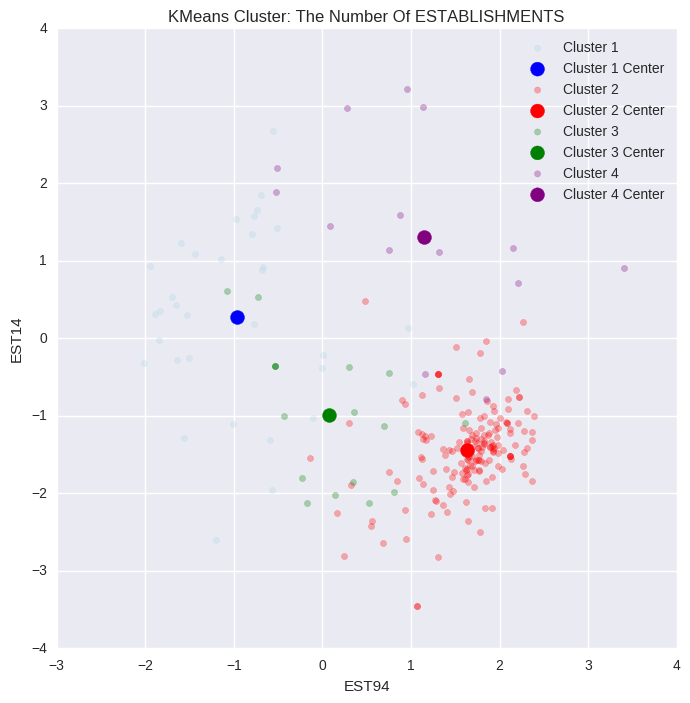

In [41]:
pl.figure(figsize=(8,8))
pl.scatter(CB[mod_km.labels_ == 0].iloc[:,4], CB[mod_km.labels_ == 0].iloc[:,24], \
           color='lightblue', alpha=0.3, label="Cluster 1")
pl.scatter(centers[0][0], centers[0][-1], marker='o', s=100, color='blue', label="Cluster 1 Center")

pl.scatter(CB[mod_km.labels_ == 1].iloc[:,4], CB[mod_km.labels_ == 1].iloc[:,24], \
           color='red', alpha=0.3, label="Cluster 2")
pl.scatter(centers[1][0], centers[1][-1], marker='o', s=100, color='red', label="Cluster 2 Center")

pl.scatter(CB[mod_km.labels_ == 2].iloc[:,4], CB[mod_km.labels_ == 2].iloc[:,24], \
           color='green', alpha=0.3, label="Cluster 3")
pl.scatter(centers[2][0], centers[2][-1], marker='o', s=100, color='green', label="Cluster 3 Center")

pl.scatter(CB[mod_km.labels_ == 3].iloc[:,4], CB[mod_km.labels_ == 3].iloc[:,24], \
           color='purple', alpha=0.3, label="Cluster 4")
pl.scatter(centers[3][0], centers[3][-1], marker='o', s=100, color='purple', label="Cluster 4 Center")

# pl.scatter(CB[mod_km.labels_ == 4].iloc[:,4], CB[mod_km.labels_ == 4].iloc[:,24], \
#            color='orange', alpha=0.3, label="Cluster 5")
# pl.scatter(centers[4][0], centers[4][-1], marker='*', s=100, color='orange', label="Cluster 5 Center")

pl.xlabel("EST94")
pl.ylabel("EST14")
pl.title("KMeans Cluster: The Number Of ESTABLISHMENTS")
pl.legend(fontsize=10, loc='best')

#### KMeans Cluster for EST94~EST14 has shown in above plot. The Figure that data points from different clusters gather aroud their own cluster centers with a little overlap.

<br/><br/>

## 5. DBSCAN

In [56]:
mod_DBSCAN = DBSCAN(min_samples=4).fit(CB.iloc[:,range(4,25)])

In [57]:
unique(mod_DBSCAN.labels_)

array([-1,  0,  1,  2,  3])

### DBSCAN: 5 Clusters In Total


## 6. Hierarchical Clustering

In [45]:
Z = linkage(CB.iloc[:,range(4,25)], 'ward')

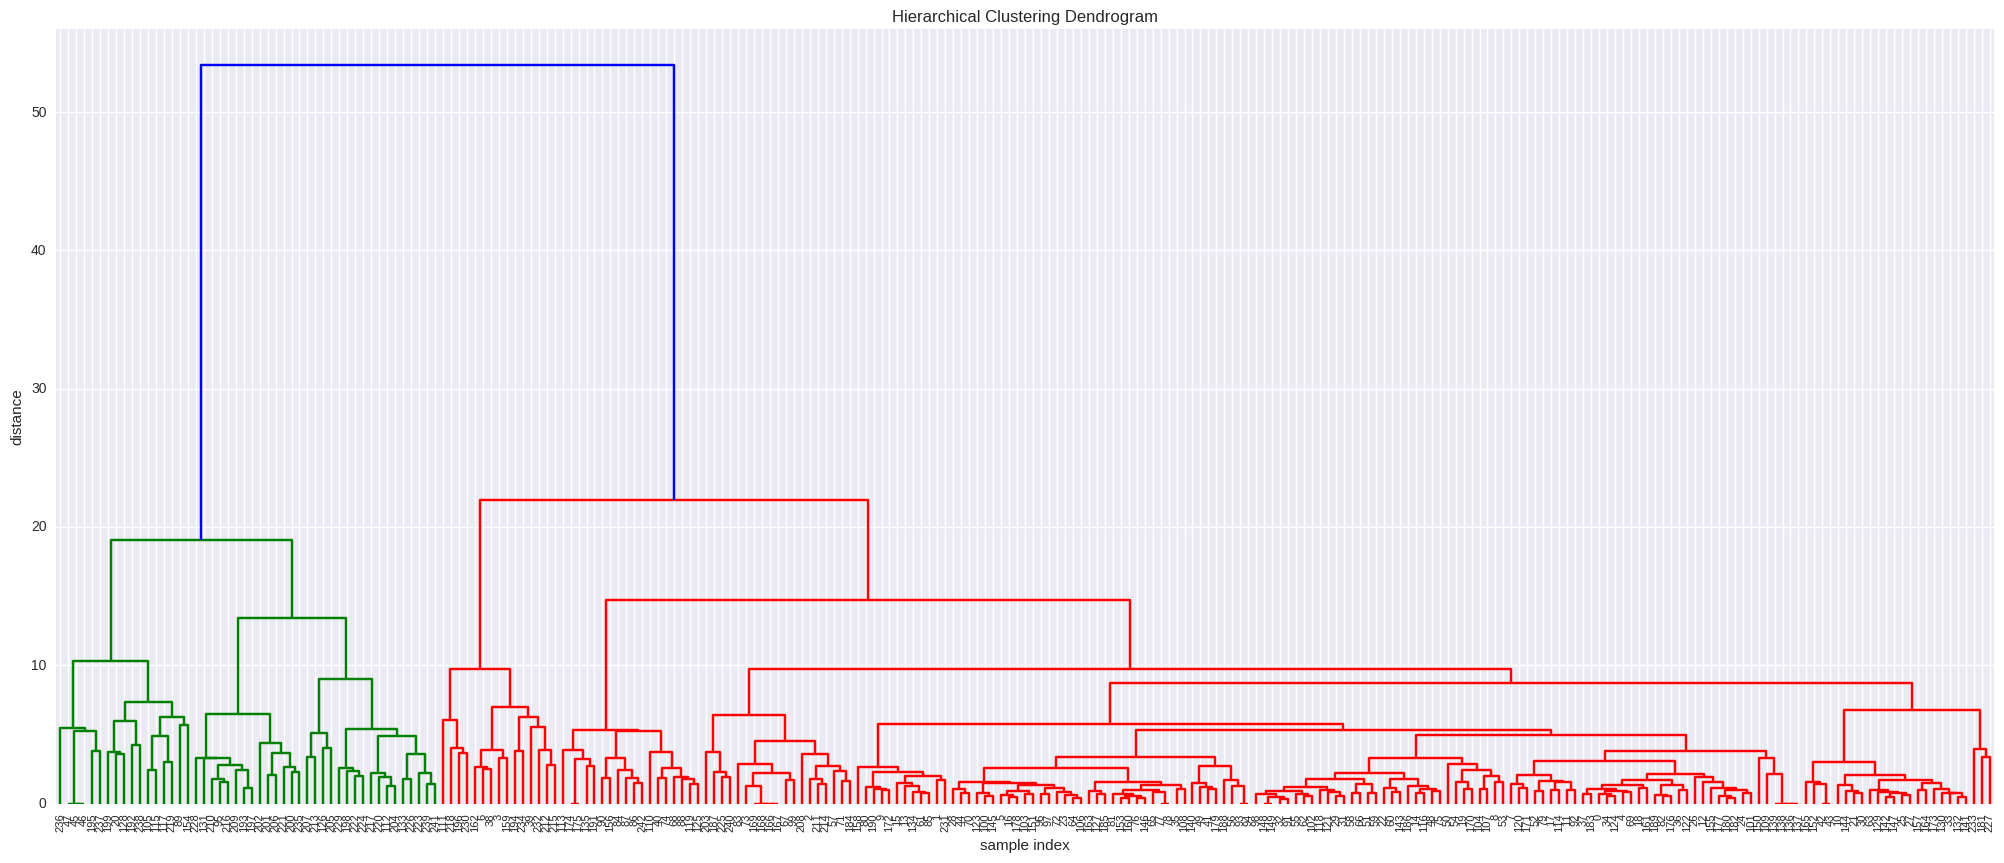

In [46]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
pl.show()

### Plot above shows the result of hierarchical clustering.

In [47]:
HC_label = fcluster(Z, 4, criterion='maxclust')

<br/><br/>
## 7. Plot

In [48]:
CB2 = CB.copy()
CB2['km'] = mod_km.labels_
CB2['DBSCAN'] = mod_DBSCAN.labels_
CB2['HC'] = HC_label
CB2['HC_'] = CB2.HC.replace([1,4],[4,1])

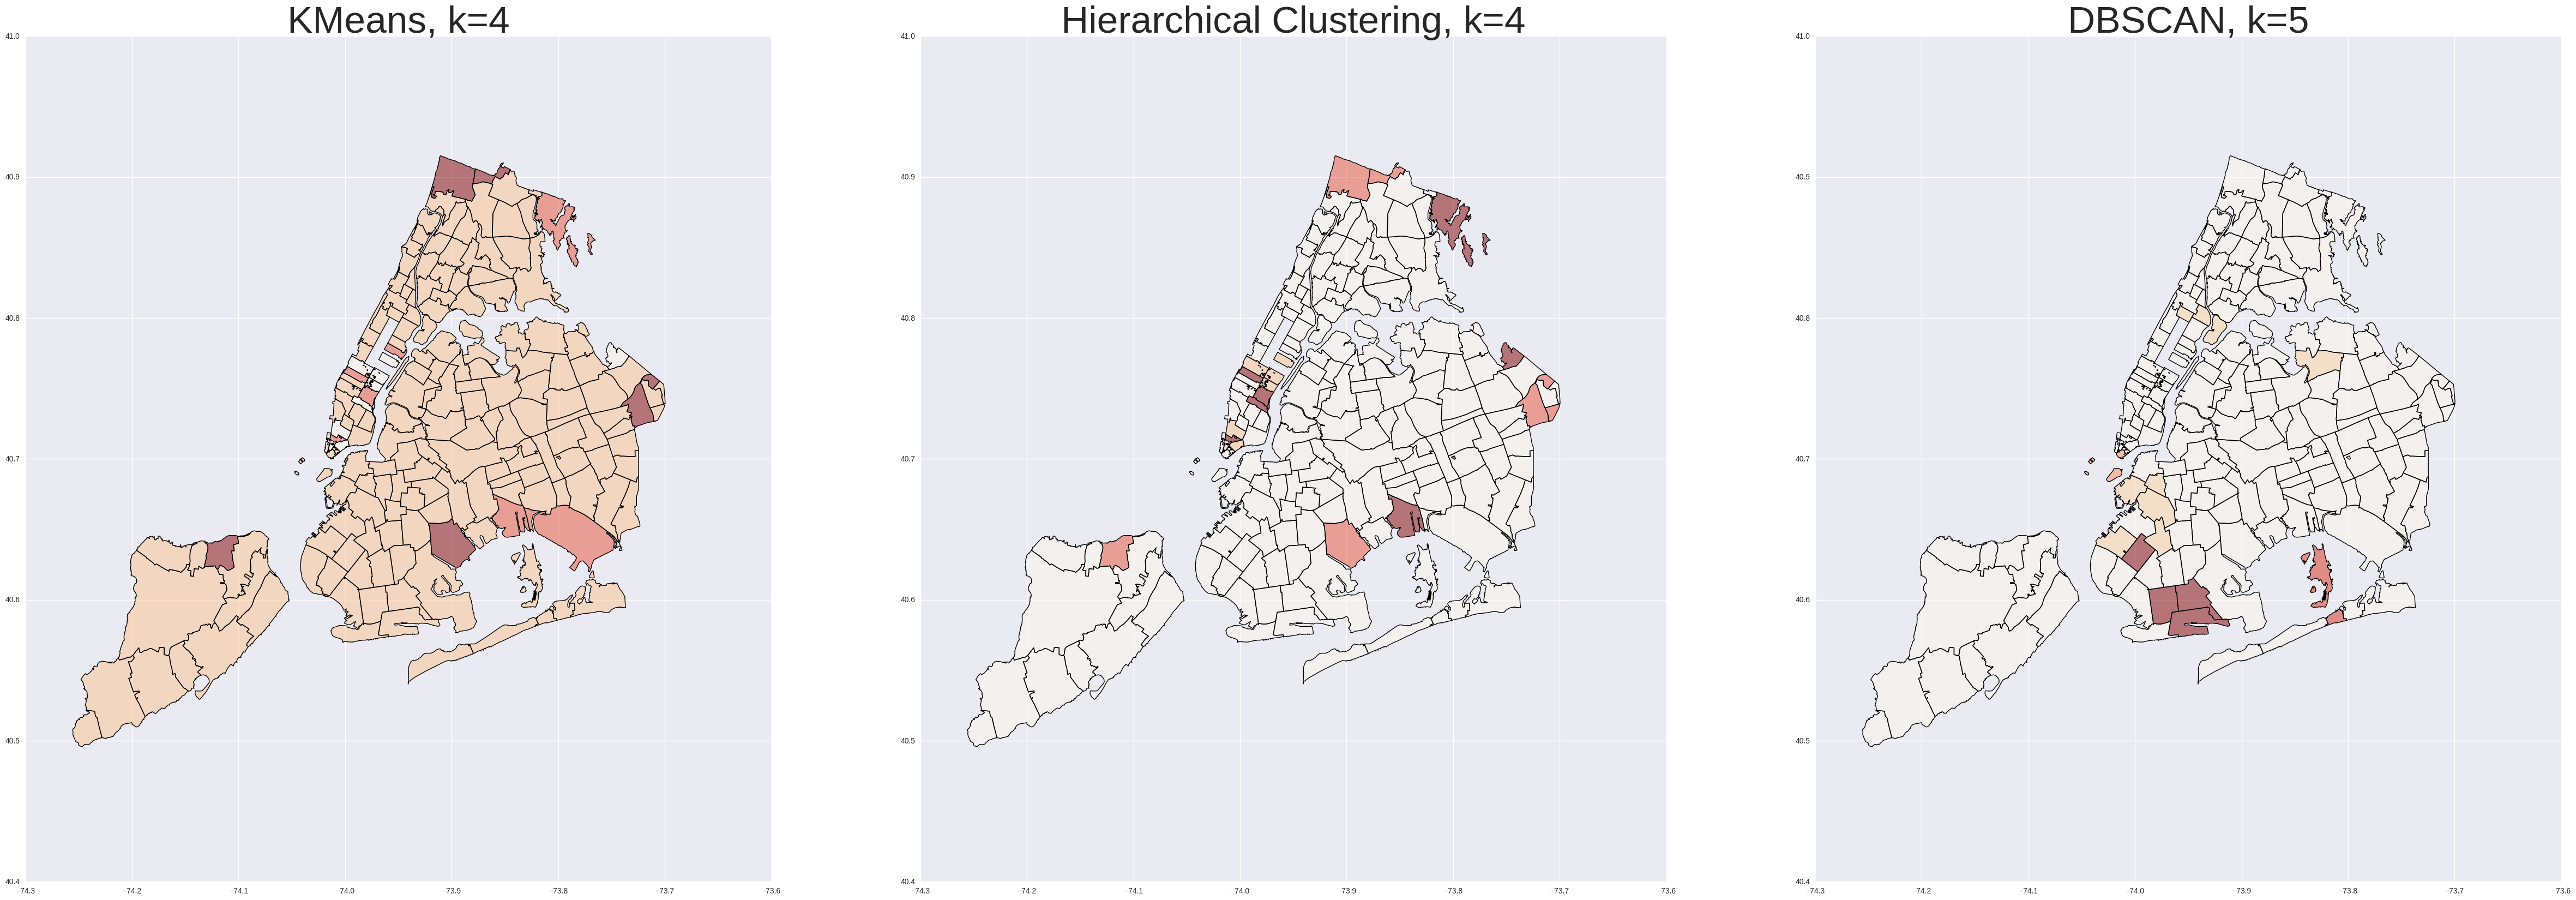

In [58]:
f, (ax1, ax2, ax3) = pl.subplots(1,3,figsize=(60,20))
CB2.plot(colormap='OrRd', column='km', ax=ax1, categorical=True, k=4)
ax1.set_title("KMeans, k=4", fontsize=50)
CB2.plot(colormap='OrRd', column='HC_', ax=ax2, categorical=True, k=4)
ax2.set_title("Hierarchical Clustering, k=4", fontsize=50)
CB2.plot(colormap='OrRd', column='DBSCAN', ax=ax3, categorical=True, k=5)
ax3.set_title("DBSCAN, k=5", fontsize=50)

### Above Plots shows cluster result of three clustering methods (k-means, Hierarchical Clustering and DBSCN)

<br/><br/>
## 8. Interpretation and Exploration

Overall, the clustering results are similar to each other. What I think is really interesting is the results show that the pattern of some area in manhattan is similar in south brooklyn

In [ ]:
#@Review: Insufficeitn Comparison and interpretation!